In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
latest_date = transactions['TransactionDate'].max()
rfm = transactions.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (latest_date - x.max()).days,
    'TransactionID': 'count', 
    'TotalValue': 'sum' }).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [4]:
customer_features = customers.merge(rfm, on='CustomerID', how='left')
customer_features.fillna(0, inplace=True)

In [5]:
customer_features['Monetary'] = np.log1p(customer_features['Monetary'])
customer_features['Frequency'] = np.log1p(customer_features['Frequency'])

In [6]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['Recency', 'Frequency', 'Monetary']])

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

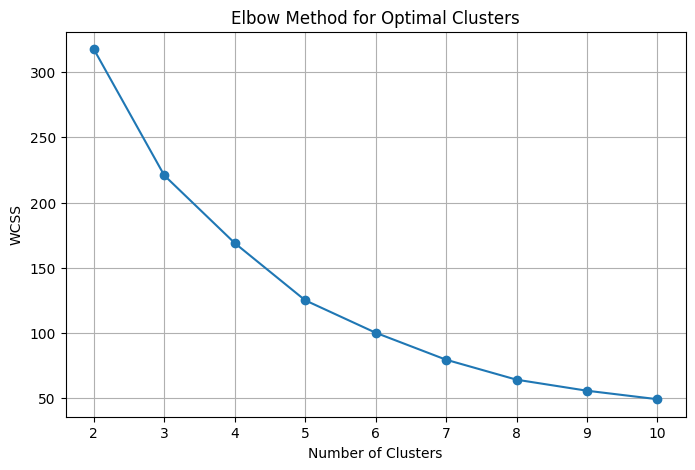

In [7]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

wcss = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pca_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid()
plt.show()

In [8]:
# As there is no prominent elbow
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(pca_features)
customer_features['Cluster'] = kmeans.labels_

C:\Users\HP\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [9]:
silhouette_avg = silhouette_score(pca_features, kmeans.labels_)
db_index = davies_bouldin_score(pca_features, kmeans.labels_)

print(f"Silhouette Score: {silhouette_avg:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")

Silhouette Score: 0.41
Davies-Bouldin Index: 0.74


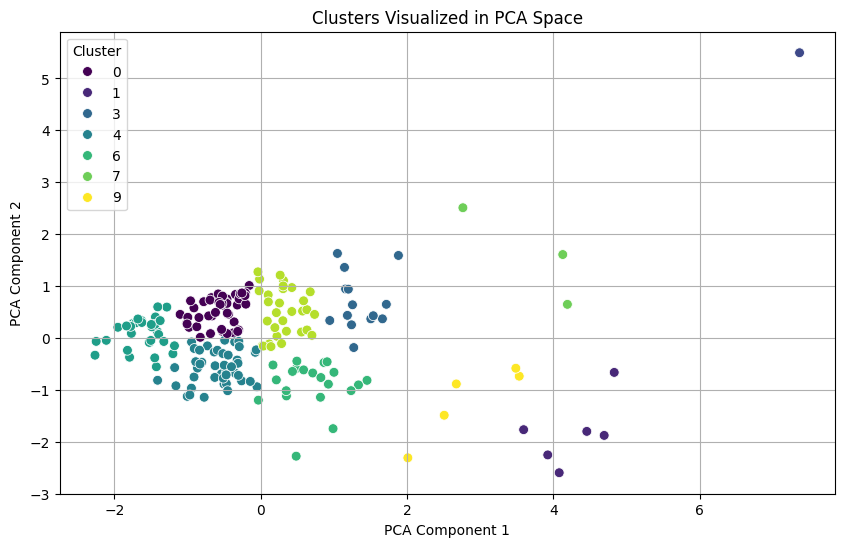

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_features['Cluster'], palette='viridis', s=50
)
plt.title("Clusters Visualized in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid()
plt.show()

In [11]:
cluster_summary = customer_features.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()
print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
   Cluster     Recency  Frequency  Monetary
0        0   22.363636   1.805435  8.068448
1        1  323.000000   0.693147  6.212821
2        2    0.000000   0.000000  0.000000
3        3   70.357143   1.229430  6.974737
4        4   92.409091   1.974018  8.387238
5        5   20.193548   2.224877  8.656199
6        6  149.000000   1.539851  7.985381
7        7   98.000000   0.693147  4.911414
8        8   48.258065   1.496750  7.708670
9        9  237.200000   0.993963  6.844739
